In [11]:
import re
import os
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

home = os.path.expanduser("~")
data_dir = os.path.join(home, 'Documents/semantic-robot/testing/results')

### Extract necessary data

In [12]:
def extract_data(filename):
    with open(filename) as f:
        content = f.read()

    test_sets = re.findall(r'Test set #\s+:\s+(.+)', content)
    number_of_examples = re.findall(r'Number of examples\s+:\s+(.+)', content)
    inference_times = re.findall(r'Inference time \[s\]\s+:\s+(.+)', content)
    memory_usage = re.findall(r'GPU memory loaded \[MB\]\s+:\s+(.+)', content)
    input_size = re.findall(r'Model input size \[MB\]\s+:\s+(.+)', content)
    model = re.findall(r'Model\s+:\s+(.+)', content)
    sliced_output = re.findall(r'Sliced output\s+:\s+(.+)', content)
    solution = re.findall(r'Solution\s+:\s+(.+)', content)
    labeled = re.findall(r'Labeled\s+:\s+(.+)', content)

    return {
        'model': list(map(str, model)),
        'test_set': list(map(int, test_sets)),
        'num_examples': list(map(int, number_of_examples)),
        'sliced_output': list(map(str, sliced_output)),
        'solution': list(map(str, solution)),
        'inference_time': list(map(float, inference_times)),
        'memory_usage': list(map(float, memory_usage)),
        'input_size': list(map(float, input_size)),
        'labeled': list(map(str, labeled))
    }

### Read files of results from 4-bit, 8-bit, half and full precision for both labeled and unlabeled examples

In [13]:
num = 'final_'
data_4bit= extract_data(os.path.join(data_dir, num + 'mistral_results_4bit_labeled.txt'))

df_4bit = pd.DataFrame(data_4bit)

### 4-bit labeled

In [15]:
inf_times = np.zeros(max(df_4bit['num_examples']))
mem_usages = np.zeros(max(df_4bit['num_examples']))
input_sizes = np.zeros(max(df_4bit['num_examples']))

sliced_outputs = []

for i in range(2, max(df_4bit['num_examples'])+1):
    idxs = df_4bit.loc[df_4bit['num_examples'] == i]
    
    inference_times = [float(x) for x in idxs['inference_time']]
    if inference_times:
        avg_inference_time = sum(inference_times) / len(inference_times)
    else:
        avg_inference_time = 0

    memory_usage = [float(x) for x in idxs['memory_usage']]
    if memory_usage:    
        avg_memory_usage = sum(memory_usage) / len(memory_usage)
    else:
        avg_memory_usage = 0

    input_size = [float(x) for x in idxs['input_size']]
    if input_size:    
        avg_input_size = sum(input_size) / len(input_size)
    else:
        avg_input_size = 0
    
    sliced_output = [str(x) for x in idxs['sliced_output']]
    sliced_outputs.append(sliced_output)

    inf_times[i-2] = avg_inference_time
    mem_usages[i-2] = avg_memory_usage
    input_sizes[i-2] = avg_input_size

sliced_outputs = list(map(list, zip(*sliced_outputs)))

solutions = []
for i in range(1, max(df_4bit['test_set'])+1):
    idxs = df_4bit.loc[df_4bit['test_set'] == i]
    first = idxs['solution'].iloc[0]
    solutions.append(str(first))

Denne delen er utkast til hvordan jeg kan automatisere det å sjekke hvor god mistral output er.

Til nå har jeg skilt ut alle instance-typer.

In [16]:
sol_instances_dicts = []
sol_predicates_dicts = []
sol_goals_dicts = []

counter = 1

for sols in solutions:
    counter+=1
    
    instances = sols.split('predicate')[0]
    predicates = sols.split('goal ')[0].replace(instances, '')
    goals = sols.replace(instances + predicates, '')

    instances = instances.replace("|", " |")
    predicates = predicates.replace("|", " |")
    goals = goals.replace("|", " |")

    instances = instances.split()
    predicates = predicates.split()
    goals = goals.split()

    # iterate over the words in instances, predicates and goals and delete the char | where is is
    for i in range(len(instances)):
        instances[i] = instances[i].replace("|", "")
    for i in range(len(predicates)):
        predicates[i] = predicates[i].replace("|", "")
    for i in range(len(goals)):
        goals[i] = goals[i].replace("|", "")

    # remove the empty strings from the lists
    instances = list(filter(None, instances))
    predicates = list(filter(None, predicates))
    goals = list(filter(None, goals))

    # create instances dictionary
    instances_dict = {}
    key = None
    for word in instances:
        if word == 'instance':
            if key is not None:
                if key in instances_dict:
                    print(f'Key {key} already exists in instances {counter}.')
                    key = key+'_copy'
                    instances_dict[key] = value
                else:
                    instances_dict[key] = value
            key = None
            value = None
        elif key is None:
            key = word
        else:
            value = word
    if key is not None:
        if key in instances_dict:
            print(f'Key {key} already exists in instances {counter}.')
            key = key+'_copy'
            instances_dict[key] = value
        else:    
            instances_dict[key] = value

    # create predicates dictionary
    predicates_dict = {}
    key = ''
    value = ''
    for i in range(len(predicates)):
        if predicates[i] == 'predicate':
            if key:
                if key in predicates_dict:
                    print(f"Key {key} already exists in predicates {counter}.")
                    key = key+'_copy'
                    predicates_dict[key] = value
                else:
                    predicates_dict[key] = value

            value = predicates[i+1] 
            key = ' '.join(predicates[i+2:])  
            next_predicate_index = key.find('predicate') 
            if next_predicate_index != -1:
                key = key[:next_predicate_index].strip()
    if key:
        if key in predicates_dict:
            print(f"Key {key} already exists in predicates {counter}.")
            key = key+'_copy'
            predicates_dict[key] = value
        else:
            predicates_dict[key] = value

    # create goals dictionary
    goals_dict = {}
    key = ''
    value = ''
    for i in range(len(goals)):
        if goals[i] == 'goal':
            if key:
                if key in goals_dict:
                    print(f"Key {key} already exists in goals {counter}.")
                    key = key+'_copy'
                    goals_dict[key] = value
                else:
                    goals_dict[key] = value

            value = goals[i+1] 
            key = ' '.join(goals[i+2:])  
            next_goal_index = key.find('goal') 
            if next_goal_index != -1:
                key = key[:next_goal_index].strip()
    if key:
        if key in goals_dict:
            print(f"Key {key} already exists in goals {counter}.")
            key = key+'_copy'
            goals_dict[key] = value
        else:
            goals_dict[key] = value

    sol_instances_dicts.append(instances_dict)
    sol_predicates_dicts.append(predicates_dict)
    sol_goals_dicts.append(goals_dict)

Key book1 already exists in goals 9.


Write outputs to file for comparison

In [17]:
counter = 0
num_of_ex_list = []

with open('output_results_labeled.txt', 'w') as f:
    for i in range(len(sliced_outputs)):        
        for j in range(len(sliced_outputs[i])):
            instance_count_out = sliced_outputs[i][j].count('instance')
            predicate_count_out = sliced_outputs[i][j].count('predicate')
            goal_count_out = sliced_outputs[i][j].count('goal')

            instance_count_sol = solutions[i].count('instance')
            predicate_count_sol = solutions[i].count('predicate')
            goal_count_sol = solutions[i].count('goal')

            if instance_count_out==instance_count_sol and predicate_count_out==predicate_count_sol and goal_count_out==goal_count_sol:
                counter+=1
                num_of_ex_list.append(j+2)

            f.write(f'Test set {i+1} - number of examples {j+2}\n')
            f.write(f'{sliced_outputs[i][j]}\n')
            f.write(f'{solutions[i]}\n')
            f.write(f'instances: {instance_count_out}/{instance_count_sol} - predicate count: {predicate_count_out}/{predicate_count_sol} - goal count: {goal_count_out}/{goal_count_sol}\n\n')

         # count the number of times each number of examples appears
num_of_ex_list = np.array(num_of_ex_list)
unique, counts = np.unique(num_of_ex_list, return_counts=True)
print(np.asarray((unique, counts)).T)   

[[ 3  1]
 [ 4  1]
 [ 5  2]
 [ 8  1]
 [ 9  2]
 [10  1]
 [13  1]
 [14  3]
 [18  1]
 [21  2]
 [26  3]
 [28  1]
 [29  2]
 [32  1]]


In [19]:
out_instances_dicts = [[] for _ in range(len(sliced_outputs))]
out_predicates_dicts = [[] for _ in range(len(sliced_outputs))]
out_goals_dicts = [[] for _ in range(len(sliced_outputs))]

counter = 1

for i in range(len(sliced_outputs)):        
    for j in range(len(sliced_outputs[i])):
        instances = sliced_outputs[i][j].split('predicate')[0]
        predicates = sliced_outputs[i][j].split('goal ')[0].replace(instances, '')
        goals = sliced_outputs[i][j].replace(instances + predicates, '')

        instances = instances.replace("|", " |")
        predicates = predicates.replace("|", " |")
        goals = goals.replace("|", " |")

        instances = instances.split()
        predicates = predicates.split()
        goals = goals.split()

        # iterate over the words in instances, predicates and goals and delete the char | where is is
        for k in range(len(instances)):
            instances[k] = instances[k].replace("|", "")
        for k in range(len(predicates)):
            predicates[k] = predicates[k].replace("|", "")
        for k in range(len(goals)):
            goals[k] = goals[k].replace("|", "")

        # remove the empty strings from the lists
        instances = list(filter(None, instances))
        predicates = list(filter(None, predicates))
        goals = list(filter(None, goals))

        # create instances dictionary
        instances_dict = {}
        key = None
        for word in instances:
            if word == 'instance':
                if key is not None:
                    if key in instances_dict:
                        print(f'Key {key} already exists in instances {counter}.')
                        key = key+'_copy'
                        instances_dict[key] = value
                    else:
                        instances_dict[key] = value
                key = None
                value = None
            elif key is None:
                key = word
            else:
                value = word
        if key is not None:
            if key in instances_dict:
                print(f'Key {key} already exists in instances {counter}.')
                key = key+'_copy'
                instances_dict[key] = value
            else:    
                instances_dict[key] = value

        # create predicates dictionary
        predicates_dict = {}
        key = ''
        value = ''
        for n in range(len(predicates)):
            if predicates[n] == 'predicate':
                if key:
                    if key in predicates_dict:
                        print(f"Key {key} already exists in predicates {counter}.")
                        key = key+'_copy'
                        predicates_dict[key] = value
                    else:
                        predicates_dict[key] = value

                if n+1 < len(predicates):
                    value = predicates[n+1] 
                    key = ' '.join(predicates[n+2:])  
                    next_predicate_index = key.find('predicate') 
                    if next_predicate_index != -1:
                        key = key[:next_predicate_index].strip()
        if key:
            if key in predicates_dict:
                print(f"Key {key} already exists in predicates {counter}.")
                key = key+'_copy'
                predicates_dict[key] = value
            else:
                predicates_dict[key] = value

        # create goals dictionary
        goals_dict = {}
        key = ''
        value = ''
        for n in range(len(goals)):
            if goals[n] == 'goal':
                if key:
                    if key in goals_dict:
                        print(f"Key {key} already exists in goals {counter}.")
                        key = key+'_copy'
                        goals_dict[key] = value
                    else:
                        goals_dict[key] = value

                value = goals[n+1] 
                key = ' '.join(goals[n+2:])  
                next_goal_index = key.find('goal') 
                if next_goal_index != -1:
                    key = key[:next_goal_index].strip()
        if key:
            if key in goals_dict:
                print(f"Key {key} already exists in goals {counter}.")
                key = key+'_copy'
                goals_dict[key] = value
            else:
                goals_dict[key] = value

        out_instances_dicts[i].append(instances_dict)
        out_predicates_dicts[i].append(predicates_dict)
        out_goals_dicts[i].append(goals_dict)

Key Task1 already exists in instances 1.
Key Task2 already exists in instances 1.
Key Location1 already exists in instances 1.
Key Location2 already exists in instances 1.
Key false already exists in predicates 1.
Key null already exists in predicates 1.
Key Task1 Worker1 already exists in goals 1.
Key null already exists in predicates 1.
Key null already exists in predicates 1.
Key null already exists in predicates 1.
Key null already exists in predicates 1.
Key null already exists in predicates 1.
Key Worker1 already exists in instances 1.
Key Task1 already exists in instances 1.
Key Task2 already exists in instances 1.
Key Task1 Worker1 already exists in predicates 1.
Key Worker1 already exists in instances 1.
Key instance NULL task already exists in predicates 1.
Key WORKER1 already exists in predicates 1.
Key TASK2 NULL already exists in predicates 1.
Key WORKER1 already exists in predicates 1.
Key TASK2 false already exists in predicates 1.
Key zone already exists in instances 1.

In [24]:
len(out_predicates_dicts[0])

31

Compare instances, predicates and goals.
I don't compare the exact match, but have to visually compare them

In [25]:
with open('compare_instances_labeled.txt', 'w') as f:
    for i in range(len(sol_instances_dicts)):
        for j in range(len(out_instances_dicts[i])):
            f.write(f'======================================== Examples {j+2} - {i+1} ========================================\n')
            f.write(f'                      Solution                                              Output\n')
            f.write(f'-------------------------------------------------------------------------------------------------\n')

            sol_keys = list(sol_instances_dicts[i].keys())
            out_keys = list(out_instances_dicts[i][j].keys())

            max_len = max(len(sol_keys), len(out_keys))

            for k in range(max_len):
                sol_key = sol_keys[k] if k < len(sol_keys) else ''
                sol_value = sol_instances_dicts[i].get(sol_key, '')
                out_key = out_keys[k] if k < len(out_keys) else ''
                out_value = out_instances_dicts[i][j].get(out_key, '')

                sol_str = f'{sol_key:>26}: {sol_value:<37}'
                out_str = f'{out_key:>13}: {out_value}'
                f.write(f'{sol_str}{out_str}\n')
                f.write(f'-------------------------------------------------------------------------------------------------\n')

            f.write(f'\n\n')

with open('compare_predicates_labeled.txt', 'w') as f:
    for i in range(len(sol_predicates_dicts)):        
        for j in range(len(out_predicates_dicts[i])):
            f.write(f'======================================== Examples {j+2} - {i+1} ========================================\n')
            f.write(f'                      Solution                                              Output\n')
            f.write(f'-------------------------------------------------------------------------------------------------\n')

            sol_keys = list(sol_predicates_dicts[i].keys())
            out_keys = list(out_predicates_dicts[i][j].keys())

            max_len = max(len(sol_keys), len(out_keys))

            for k in range(max_len):
                sol_key = sol_keys[k] if k < len(sol_keys) else ''
                sol_value = sol_predicates_dicts[i].get(sol_key, '')
                out_key = out_keys[k] if k < len(out_keys) else ''
                out_value = out_predicates_dicts[i][j].get(out_key, '')

                sol_str = f'{sol_key:>26}: {sol_value:<37}'
                out_str = f'{out_key:>13}: {out_value}'
                f.write(f'{sol_str}{out_str}\n')
                f.write(f'-------------------------------------------------------------------------------------------------\n')

            f.write(f'\n\n')

with open('compare_goals_labeled.txt', 'w') as f:
    for i in range(len(sol_goals_dicts)):
        for j in range(len(out_goals_dicts[i])):
            f.write(f'======================================== Examples {j+2} - {i+1} ========================================\n')
            f.write(f'                      Solution                                              Output\n')
            f.write(f'-------------------------------------------------------------------------------------------------\n')

            sol_keys = list(sol_goals_dicts[i].keys())
            out_keys = list(out_goals_dicts[i][j].keys())

            max_len = max(len(sol_keys), len(out_keys))

            for k in range(max_len):
                sol_key = sol_keys[k] if k < len(sol_keys) else ''
                sol_value = sol_goals_dicts[i].get(sol_key, '')
                out_key = out_keys[k] if k < len(out_keys) else ''
                out_value = out_goals_dicts[i][j].get(out_key, '')

                sol_str = f'{sol_key:>26}: {sol_value:<37}'
                out_str = f'{out_key:>13}: {out_value}'
                f.write(f'{sol_str}{out_str}\n')
                f.write(f'-------------------------------------------------------------------------------------------------\n')

            f.write(f'\n\n')

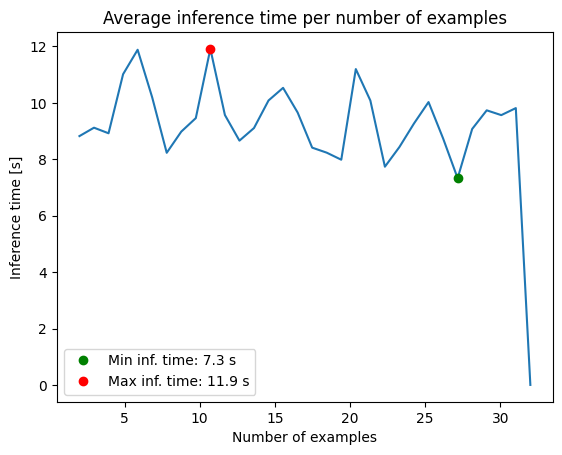

In [26]:
x = np.linspace(2, 32, len(inf_times))
plt.plot(x, inf_times)
plt.title('Average inference time per number of examples')
plt.xlabel('Number of examples')
plt.ylabel('Inference time [s]')

min_inf_time = min(x for x in inf_times if x != 0)
max_inf_time = max(inf_times)
min_inf_time_idx = np.where(inf_times == min_inf_time)
max_inf_time_idx = np.where(inf_times == max_inf_time)

plt.plot(x[min_inf_time_idx], min_inf_time, 'go', label=f'Min inf. time: {round(min_inf_time, 1)} s')
plt.plot(x[max_inf_time_idx], max_inf_time, 'ro', label=f'Max inf. time: {round(max_inf_time, 1)} s')
plt.legend()

plt.show()

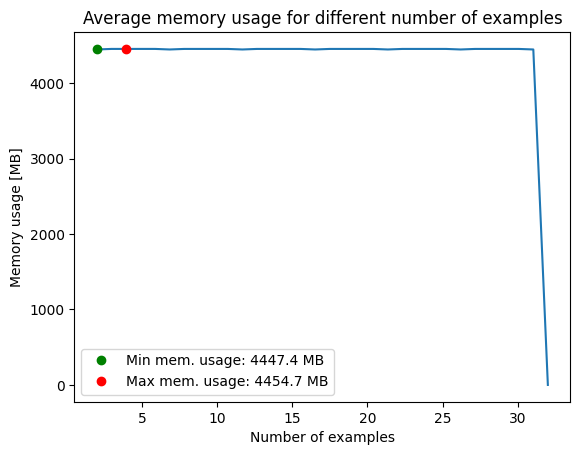

In [27]:
x = np.linspace(2, 32, len(mem_usages))
plt.plot(x, mem_usages)
plt.title('Average memory usage for different number of examples')
plt.xlabel('Number of examples')
plt.ylabel('Memory usage [MB]')

min_mem_usage = min(x for x in mem_usages if x != 0)
max_mem_usage = max(mem_usages)
min_mem_usage_idx = np.where(mem_usages == min_mem_usage)
max_mem_usage_idx = np.where(mem_usages == max_mem_usage)

plt.plot(x[min_mem_usage_idx[0]][random.randint(0, len(min_mem_usage_idx))], min_mem_usage, 'go', label=f'Min mem. usage: {round(min_mem_usage, 1)} MB')
plt.plot(x[max_mem_usage_idx[0]][random.randint(0, len(min_mem_usage_idx))], max_mem_usage, 'ro', label=f'Max mem. usage: {round(max_mem_usage, 1)} MB')
plt.legend()

plt.show()

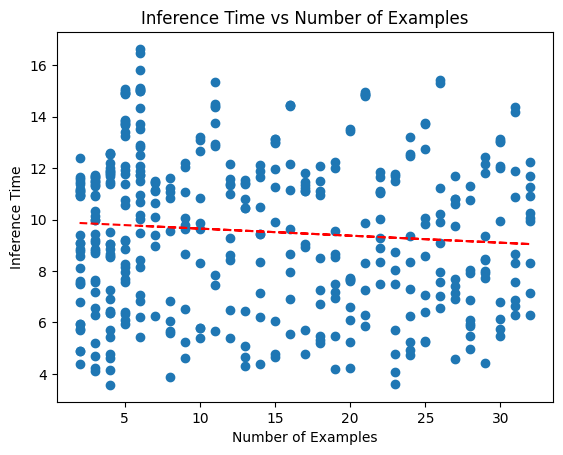

In [28]:
plt.scatter(data_4bit['num_examples'], data_4bit['inference_time'])
plt.xlabel('Number of Examples')
plt.ylabel('Inference Time')
plt.title('Inference Time vs Number of Examples')

z = np.polyfit(data_4bit['num_examples'], data_4bit['inference_time'], 1)
p = np.poly1d(z)
plt.plot(data_4bit['num_examples'], p(data_4bit['num_examples']), "r--")

plt.show()

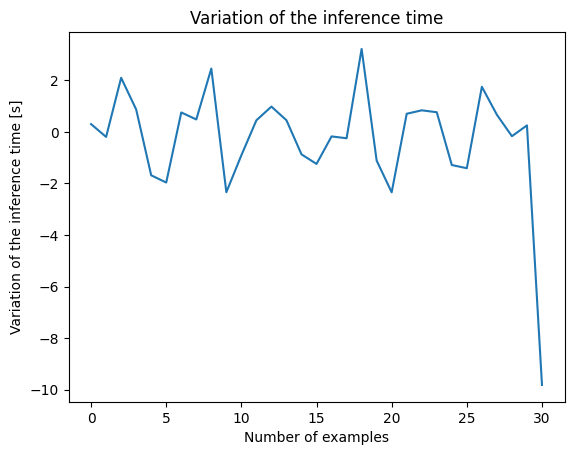

In [29]:

# compute the variation of the inference time
inf_time_variation = np.diff(inf_times)

plt.plot(inf_time_variation)
plt.title('Variation of the inference time')
plt.xlabel('Number of examples')
plt.ylabel('Variation of the inference time [s]')

plt.show()

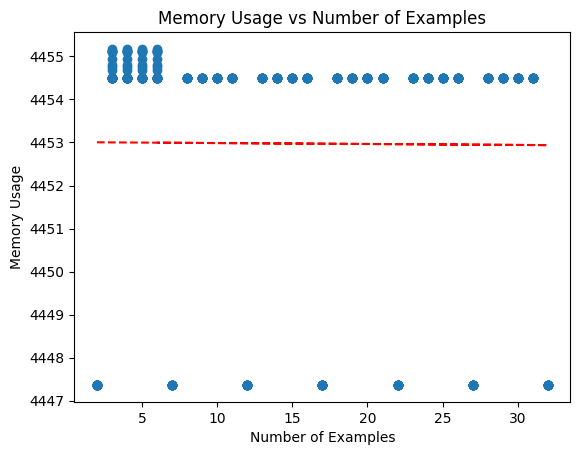

In [30]:
plt.scatter(data_4bit['num_examples'], data_4bit['memory_usage'])
plt.xlabel('Number of Examples')
plt.ylabel('Memory Usage')
plt.title('Memory Usage vs Number of Examples')

z = np.polyfit(data_4bit['num_examples'], data_4bit['memory_usage'], 1)
p = np.poly1d(z)
plt.plot(data_4bit['num_examples'], p(data_4bit['num_examples']), "r--")

plt.show()

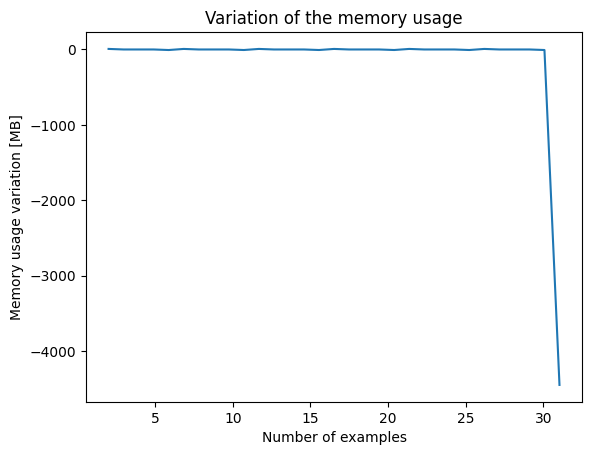

In [31]:
# compute the variation of the memory usage
mem_usages = np.array(mem_usages)
mem_usages_diff = np.diff(mem_usages)
plt.plot(x[:-1], mem_usages_diff)
plt.title('Variation of the memory usage')
plt.xlabel('Number of examples')
plt.ylabel('Memory usage variation [MB]')
plt.show()